In [74]:
IS_KAGGLE = True

if IS_KAGGLE:
    INPUT_FOLDER = '/kaggle/input/linking-writing-processes-to-writing-quality'

In [75]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import copy

In [76]:
def preprocess():
    df_raw_train = pd.read_csv(f'{INPUT_FOLDER}/train_logs.csv')
    df_raw_test = pd.read_csv(f'{INPUT_FOLDER}/test_logs.csv')
    df_raw = pd.concat((df_raw_train, df_raw_test)).reset_index(False)
    df = pd.DataFrame({
    'id': df_raw["id"].unique()
    })
    df['is_test'] = df['id'].isin(df_raw_test['id'].unique())
    df_word = df_raw.groupby("id")['word_count'].max()
    df = pd.merge(df, df_word, on="id", how="left")
    df_raw['current_min'] = df_raw["down_time"]//60000
    df_event = df_raw.groupby("id")['event_id'].count()

    df = pd.merge(df, df_event, on="id", how="left")
    df = df.rename(columns={"event_id": "event_count"})
    df_time = df_raw.groupby("id")['current_min'].max()
    df = pd.merge(df, df_time, on="id", how="left")
    df = df.rename(columns={"current_min": "writing_time_min"})
    df['events_per_min'] = df["event_count"] / df['writing_time_min']
    filter_text_change = df_raw["text_change"]!="NoChange"
    df_filtered = df_raw[filter_text_change]
    df_text_change = df_filtered.groupby("id")['text_change'].count()

    df = pd.merge(df, df_text_change, on="id", how="left")
    df = df.rename(columns={"text_change": "text_change_count"})
    df['text_changes_per_min'] = df["text_change_count"] / df['writing_time_min']
    sentence_filter = df_raw[(df_raw["text_change"].str.match('\.')) & (df_raw['activity'] != 'Remove/Cut')]
    sentence_filter = df_raw[df_raw["up_event"] == '.']
    df_sentence_count = sentence_filter.groupby("id")['text_change'].count()

    df = pd.merge(df, df_sentence_count, on="id", how="left")
    df = df.rename(columns={"text_change": "sentence_count"})
    for activity in ['Input', 'Remove/Cut', 'Paste', 'Replace', 'Nonproduction']:
      df_activity_count = df_raw[df_raw['activity'] == activity].groupby("id")['activity'].count()
      column_name = f'{activity}_count'
      df_activity_count.name = column_name
      df = pd.merge(df, df_activity_count, on="id", how="left")
      df[column_name] = df[column_name].fillna(0)
    df_raw['IKI'] = df_raw['down_time'] - df_raw.groupby('id')['up_time'].shift(1)
    df_raw['IKI'] = df_raw['IKI'].fillna(0)
    df_raw['IKI'] = df_raw['IKI'].clip(0)

    PAUSE_THRESHOLD = 2000

    pauses_count = df_raw[df_raw['IKI'] > PAUSE_THRESHOLD].groupby('id')['IKI'].count()
    pauses_count.name = 'pauses_count'
    df = pd.merge(df, pauses_count, on="id", how="left")
    pauses_mean_duration = df_raw[df_raw['IKI'] > PAUSE_THRESHOLD].groupby('id')['IKI'].mean().round(0)
    pauses_mean_duration.name = 'pause_mean_duration'
    df = pd.merge(df, pauses_mean_duration, on="id", how="left")
    pauses_time_sum = df_raw[df_raw['IKI'] > PAUSE_THRESHOLD].groupby('id')['IKI'].sum()
    pauses_time_sum.name = 'pauses_time_sum'
    df = pd.merge(df, pauses_time_sum, on="id", how="left")
    writing_time_ms = df_raw.groupby('id')['up_time'].max()
    writing_time_ms.name = 'writing_time_ms'
    df = pd.merge(df, writing_time_ms, on="id", how="left")

    df['pause_per_min'] = (df["pauses_count"] / df['writing_time_min']).round(2)

    df['pauses_share'] = (df["pauses_time_sum"] / df['writing_time_ms']).round(2)
    df_freq = df_raw.groupby("id").agg({
      'down_time': ['min', 'max'],
      'activity': lambda x: x.value_counts().index[0]
    }).reset_index()
    df_freq.columns = ['id', 'start_time', 'end_time', 'most_frequent_activity']
    df = pd.merge(df, df_freq, on="id", how='left')
   
    df['total_writing_time'] = df['end_time'] - df['start_time']
    df['Avg_time_between_events'] = df['total_writing_time'] / df['event_count']
    df['overtime_writing'] = df['writing_time_min'] > 30

    total_action_time = df_raw.groupby('id')['action_time'].sum()
    df = pd.merge(df, total_action_time, on='id', how='left')

    df['average_action_time'] = df['action_time'] / df['event_count']
    df = df.drop(columns=['action_time'])
    df_raw['chars_added'] = df_raw['activity'].apply(lambda x: 1 if x in ['Input', 'Paste'] else 0)
    df_raw['chars_removed'] = df_raw['activity'].apply(lambda x: 1 if x == 'Remove/Cut' else 0)

    total_chars_added = df_raw.groupby('id')['chars_added'].sum()
    total_chars_removed = df_raw.groupby('id')['chars_removed'].sum()

    df = pd.merge(df, total_chars_added, on='id', how='left')
    df = pd.merge(df, total_chars_removed, on='id', how='left')

    df['total_characters'] = df['chars_added'] - df['chars_removed']
    df.drop(columns=['chars_added', 'chars_removed'], inplace=True)
    df['avg_characters_per_min'] = df['total_characters'] / df['writing_time_min']
    return df

In [77]:
df = preprocess()
df.head()

,id,is_test,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min,sentence_count,Input_count,...,pauses_share,start_time,end_time,most_frequent_activity,total_writing_time,Avg_time_between_events,overtime_writing,average_action_time,total_characters,avg_characters_per_min
0,001519c8,False,256,2557,30,85.233333,2437,81.233333,21.0,2010,...,0.66,4526,1801877,Input,1797351,702.913962,False,116.246774,1593,53.100000
1,0022f953,False,323,2454,29,84.620690,2200,75.862069,15.0,1938,...,0.66,30623,1788842,Input,1758219,716.470660,False,112.221271,1679,57.896552
2,0042269b,False,404,4136,29,142.620690,3961,136.586207,21.0,3515,...,0.63,4441,1771219,Input,1766778,427.170696,False,101.837766,3076,106.068966
3,0059420b,False,206,1556,23,67.652174,1457,63.347826,13.0,1304,...,0.55,41395,1404394,Input,1362999,875.963368,False,121.848329,1154,50.173913
4,0075873a,False,252,2531,27,93.740741,2459,91.074074,23.0,1942,...,0.63,78470,1662390,Input,1583920,625.807981,False,123.943896,1425,52.777778


In [78]:
df_labels = pd.read_csv(f"{INPUT_FOLDER}/train_scores.csv")
df = pd.merge(df, df_labels, on='id', how='left')
df.head()

,id,is_test,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min,sentence_count,Input_count,...,start_time,end_time,most_frequent_activity,total_writing_time,Avg_time_between_events,overtime_writing,average_action_time,total_characters,avg_characters_per_min,score
0,001519c8,False,256,2557,30,85.233333,2437,81.233333,21.0,2010,...,4526,1801877,Input,1797351,702.913962,False,116.246774,1593,53.100000,3.5
1,0022f953,False,323,2454,29,84.620690,2200,75.862069,15.0,1938,...,30623,1788842,Input,1758219,716.470660,False,112.221271,1679,57.896552,3.5
2,0042269b,False,404,4136,29,142.620690,3961,136.586207,21.0,3515,...,4441,1771219,Input,1766778,427.170696,False,101.837766,3076,106.068966,6.0
3,0059420b,False,206,1556,23,67.652174,1457,63.347826,13.0,1304,...,41395,1404394,Input,1362999,875.963368,False,121.848329,1154,50.173913,2.0
4,0075873a,False,252,2531,27,93.740741,2459,91.074074,23.0,1942,...,78470,1662390,Input,1583920,625.807981,False,123.943896,1425,52.777778,4.0


In [79]:
numeric_df = df.select_dtypes(include=[np.number])
matrix = numeric_df.corr()
matrix

,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min,sentence_count,Input_count,Remove/Cut_count,Paste_count,...,pause_per_min,pauses_share,start_time,end_time,total_writing_time,Avg_time_between_events,average_action_time,total_characters,avg_characters_per_min,score
word_count,1.000000,0.802209,0.053385,0.768781,0.853778,0.809176,0.717335,0.923179,0.328773,0.050082,...,-0.005454,-0.516932,-0.084652,0.055745,0.117278,-0.104446,-0.051648,0.965198,0.885709,0.635948
event_count,0.802209,1.000000,0.116629,0.933269,0.949290,0.873820,0.672225,0.929682,0.712939,0.045568,...,0.117491,-0.623018,-0.099254,0.117235,0.194790,-0.105263,-0.163237,0.849001,0.750566,0.590769
writing_time_min,0.053385,0.116629,1.000000,-0.158490,0.105899,-0.176769,0.068898,0.092081,0.120852,0.006886,...,0.002408,0.080258,0.448694,0.997566,0.806206,-0.127819,-0.006793,0.067912,-0.226260,0.021556
events_per_min,0.768781,0.933269,-0.158490,1.000000,0.889824,0.952160,0.634233,0.876933,0.648734,0.042872,...,0.096132,-0.661328,-0.122713,-0.157077,-0.092677,-0.107507,-0.156712,0.808481,0.857983,0.572806
text_change_count,0.853778,0.949290,0.105899,0.889824,1.000000,0.927889,0.697850,0.982451,0.740269,0.043071,...,0.109413,-0.618543,-0.099666,0.106995,0.183754,-0.105813,-0.102032,0.901417,0.804360,0.610146
text_changes_per_min,0.809176,0.873820,-0.176769,0.952160,0.927889,1.000000,0.651913,0.917099,0.667339,0.040375,...,0.086358,-0.652937,-0.122661,-0.174883,-0.112372,-0.107084,-0.095402,0.849085,0.908103,0.584598
sentence_count,0.717335,0.672225,0.068898,0.634233,0.697850,0.651913,1.000000,0.723481,0.380592,0.039848,...,0.026631,-0.455678,-0.070832,0.071212,0.126541,-0.532014,-0.049407,0.716620,0.647562,0.438797
Input_count,0.923179,0.929682,0.092081,0.876933,0.982451,0.917099,0.723481,1.000000,0.601898,0.046415,...,0.081762,-0.605604,-0.098976,0.093548,0.168451,-0.108391,-0.086440,0.966348,0.870975,0.643891
Remove/Cut_count,0.328773,0.712939,0.120852,0.648734,0.740269,0.667339,0.380592,0.601898,1.000000,0.012653,...,0.171083,-0.465370,-0.069841,0.120259,0.178768,-0.062302,-0.125375,0.376222,0.304710,0.290776
Paste_count,0.050082,0.045568,0.006886,0.042872,0.043071,0.040375,0.039848,0.046415,0.012653,1.000000,...,0.018119,-0.055581,0.005415,0.005530,0.002542,-0.008550,-0.015229,0.050937,0.046648,0.033638


In [80]:
df_model = copy.deepcopy(df)

In [81]:
columns_to_drop = ['Input_count', 'writing_time_min', 'end_time', 'avg_characters_per_min',  'pause_per_min', 'events_per_min', 'total_characters', 'text_change_count']
df_model.drop(columns=columns_to_drop , inplace=True)
df_model

,id,is_test,word_count,event_count,text_changes_per_min,sentence_count,Remove/Cut_count,Paste_count,Replace_count,Nonproduction_count,...,pauses_time_sum,writing_time_ms,pauses_share,start_time,most_frequent_activity,total_writing_time,Avg_time_between_events,overtime_writing,average_action_time,score
0,001519c8,False,256,2557,81.233333,21.0,417.0,0.0,7.0,120.0,...,1182600.0,1801969,0.66,4526,Input,1797351,702.913962,False,116.246774,3.5
1,0022f953,False,323,2454,75.862069,15.0,260.0,1.0,1.0,254.0,...,1174268.0,1788969,0.66,30623,Input,1758219,716.470660,False,112.221271,3.5
2,0042269b,False,404,4136,136.586207,21.0,439.0,0.0,7.0,175.0,...,1111167.0,1771669,0.63,4441,Input,1766778,427.170696,False,101.837766,6.0
3,0059420b,False,206,1556,63.347826,13.0,151.0,1.0,1.0,99.0,...,768075.0,1404469,0.55,41395,Input,1362999,875.963368,False,121.848329,2.0
4,0075873a,False,252,2531,91.074074,23.0,517.0,0.0,0.0,72.0,...,1045463.0,1662472,0.63,78470,Input,1583920,625.807981,False,123.943896,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,ffec5b38,False,413,3242,126.840000,31.0,276.0,0.0,0.0,71.0,...,738365.0,1508504,0.49,19885,Input,1488450,459.114744,False,89.277915,5.0
2470,fff05981,False,241,3619,81.647059,15.0,310.0,1.0,12.0,843.0,...,1037400.0,2070133,0.50,39727,Input,2030338,561.021829,True,83.237082,4.0
2471,0000aaaa,True,0,2,0.166667,NaN,0.0,0.0,0.0,0.0,...,421555.0,760160,0.55,338433,Input,421640,210820.000000,False,86.000000,NaN
2472,2222bbbb,True,1,2,0.181818,NaN,0.0,0.0,0.0,0.0,...,NaN,712023,NaN,290502,Input,421454,210727.000000,False,56.500000,NaN


In [82]:
df_model = df_model.drop(columns='score')
df_model.head()

,id,is_test,word_count,event_count,text_changes_per_min,sentence_count,Remove/Cut_count,Paste_count,Replace_count,Nonproduction_count,...,pause_mean_duration,pauses_time_sum,writing_time_ms,pauses_share,start_time,most_frequent_activity,total_writing_time,Avg_time_between_events,overtime_writing,average_action_time
0,001519c8,False,256,2557,81.233333,21.0,417.0,0.0,7.0,120.0,...,9537.0,1182600.0,1801969,0.66,4526,Input,1797351,702.913962,False,116.246774
1,0022f953,False,323,2454,75.862069,15.0,260.0,1.0,1.0,254.0,...,14678.0,1174268.0,1788969,0.66,30623,Input,1758219,716.470660,False,112.221271
2,0042269b,False,404,4136,136.586207,21.0,439.0,0.0,7.0,175.0,...,14431.0,1111167.0,1771669,0.63,4441,Input,1766778,427.170696,False,101.837766
3,0059420b,False,206,1556,63.347826,13.0,151.0,1.0,1.0,99.0,...,8828.0,768075.0,1404469,0.55,41395,Input,1362999,875.963368,False,121.848329
4,0075873a,False,252,2531,91.074074,23.0,517.0,0.0,0.0,72.0,...,11880.0,1045463.0,1662472,0.63,78470,Input,1583920,625.807981,False,123.943896


In [83]:
missing_values_features = df_model.isnull().sum()
missing_values_features

id                         0
is_test                    0
word_count                 0
event_count                0
text_changes_per_min       0
sentence_count             4
Remove/Cut_count           0
Paste_count                0
Replace_count              0
Nonproduction_count        0
pauses_count               2
pause_mean_duration        2
pauses_time_sum            2
writing_time_ms            0
pauses_share               2
start_time                 0
most_frequent_activity     0
total_writing_time         0
Avg_time_between_events    0
overtime_writing           0
average_action_time        0
dtype: int64

In [84]:
df_model['pauses_count'] = df_model['pauses_count'].fillna(df_model['pauses_count'].mean())
df_model['pause_mean_duration'] = df_model['pause_mean_duration'].fillna(df_model['pause_mean_duration'].median())
df_model['pauses_time_sum'] = df_model['pauses_time_sum'].fillna(df_model['pauses_time_sum'].mean())
df_model['sentence_count'] = df_model['sentence_count'].fillna(df_model['sentence_count'].mean())
df_model['pauses_share'] = df_model['pauses_share'].fillna(df_model['pauses_share'].mean())

In [85]:
missing_values_features_imputated = df_model.isnull().sum()
missing_values_features_imputated

id                         0
is_test                    0
word_count                 0
event_count                0
text_changes_per_min       0
sentence_count             0
Remove/Cut_count           0
Paste_count                0
Replace_count              0
Nonproduction_count        0
pauses_count               0
pause_mean_duration        0
pauses_time_sum            0
writing_time_ms            0
pauses_share               0
start_time                 0
most_frequent_activity     0
total_writing_time         0
Avg_time_between_events    0
overtime_writing           0
average_action_time        0
dtype: int64

In [86]:
df_model.dtypes

id                          object
is_test                       bool
word_count                   int64
event_count                  int64
text_changes_per_min       float64
sentence_count             float64
Remove/Cut_count           float64
Paste_count                float64
Replace_count              float64
Nonproduction_count        float64
pauses_count               float64
pause_mean_duration        float64
pauses_time_sum            float64
writing_time_ms              int64
pauses_share               float64
start_time                   int64
most_frequent_activity      object
total_writing_time           int64
Avg_time_between_events    float64
overtime_writing              bool
average_action_time        float64
dtype: object

In [87]:
encoder = OneHotEncoder(sparse_output=False)
most_frequent_activity_encoded = encoder.fit_transform(df_model[['most_frequent_activity']])

columns = encoder.get_feature_names_out(['most_frequent_activity'])
df_most_frequent_activity_encoded = pd.DataFrame(most_frequent_activity_encoded, columns=columns)
df_model['overtime_writing'] = df_model['overtime_writing'].astype(int)
df_features_encoded = df_model.drop(['most_frequent_activity'], axis=1)
df_features_encoded = pd.concat([df_features_encoded, df_most_frequent_activity_encoded], axis=1)

df_features_encoded

,id,is_test,word_count,event_count,text_changes_per_min,sentence_count,Remove/Cut_count,Paste_count,Replace_count,Nonproduction_count,...,pauses_time_sum,writing_time_ms,pauses_share,start_time,total_writing_time,Avg_time_between_events,overtime_writing,average_action_time,most_frequent_activity_Input,most_frequent_activity_Nonproduction
0,001519c8,False,256,2557,81.233333,21.000000,417.0,0.0,7.0,120.0,...,1.182600e+06,1801969,0.660000,4526,1797351,702.913962,0,116.246774,1.0,0.0
1,0022f953,False,323,2454,75.862069,15.000000,260.0,1.0,1.0,254.0,...,1.174268e+06,1788969,0.660000,30623,1758219,716.470660,0,112.221271,1.0,0.0
2,0042269b,False,404,4136,136.586207,21.000000,439.0,0.0,7.0,175.0,...,1.111167e+06,1771669,0.630000,4441,1766778,427.170696,0,101.837766,1.0,0.0
3,0059420b,False,206,1556,63.347826,13.000000,151.0,1.0,1.0,99.0,...,7.680750e+05,1404469,0.550000,41395,1362999,875.963368,0,121.848329,1.0,0.0
4,0075873a,False,252,2531,91.074074,23.000000,517.0,0.0,0.0,72.0,...,1.045463e+06,1662472,0.630000,78470,1583920,625.807981,0,123.943896,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,ffec5b38,False,413,3242,126.840000,31.000000,276.0,0.0,0.0,71.0,...,7.383650e+05,1508504,0.490000,19885,1488450,459.114744,0,89.277915,1.0,0.0
2470,fff05981,False,241,3619,81.647059,15.000000,310.0,1.0,12.0,843.0,...,1.037400e+06,2070133,0.500000,39727,2030338,561.021829,1,83.237082,1.0,0.0
2471,0000aaaa,True,0,2,0.166667,24.123887,0.0,0.0,0.0,0.0,...,4.215550e+05,760160,0.550000,338433,421640,210820.000000,0,86.000000,1.0,0.0
2472,2222bbbb,True,1,2,0.181818,24.123887,0.0,0.0,0.0,0.0,...,9.669443e+05,712023,0.544668,290502,421454,210727.000000,0,56.500000,1.0,0.0


In [88]:
df_labels['class'] = (df_labels['score'] * 2).astype(int)
df_labels

,id,score,class
0,001519c8,3.5,7
1,0022f953,3.5,7
2,0042269b,6.0,12
3,0059420b,2.0,4
4,0075873a,4.0,8
...,...,...,...
2466,ffb8c745,3.5,7
2467,ffbef7e5,4.0,8
2468,ffccd6fd,1.5,3
2469,ffec5b38,5.0,10


In [89]:
X = df_features_encoded.drop(['id'], axis=1)
X = X.fillna(0)
y_class = df_labels['class']
y_score = df_labels['score']  

X_test = X[X['is_test'] == True].drop(['is_test'], axis=1)
X = X[X['is_test'] == False].drop(['is_test'], axis=1)

X_train, X_val, y_train_class, y_val_class = train_test_split(X, y_class, random_state=0, test_size=0.20, stratify=y_class)
X_train.shape, X_val.shape, X_test.shape

((1976, 20), (495, 20), (3, 20))

In [90]:
smote_tomek = SMOTETomek(random_state=27, smote=SMOTE(k_neighbors=3))
X_overunder, y_overunder = smote_tomek.fit_resample(X_train, y_train_class)

<Axes: >

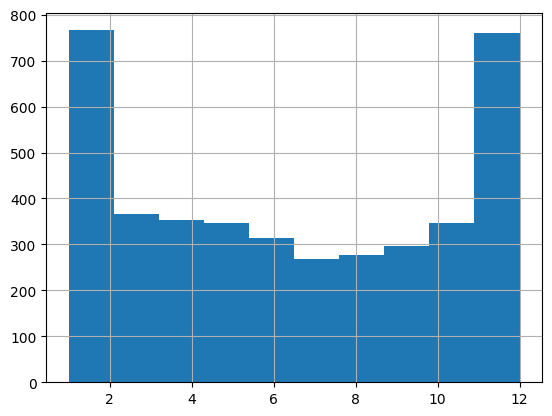

In [91]:
y_overunder.hist()

In [92]:
y_train_resampled = y_overunder / 2.0

In [93]:
scaler = preprocessing.MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_overunder)
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_overunder.columns)

In [94]:
X_val_normalized = scaler.transform(X_val)
X_val_normalized = pd.DataFrame(X_val_normalized, columns=X_val.columns)

In [95]:
X_test_normalized = scaler.transform(X_test)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

Some tries validated in kaggle

## Linear Regression

In [96]:
l_reg = LogisticRegression()
l_reg.fit(X_train, y_train_class)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [97]:
y_pred = l_reg.predict(X_val)

In [98]:
mean_squared_error(y_pred, y_val_class, squared=False)

2.070963275601209

In [99]:
test_pred_lr = l_reg.predict(X_test_normalized)
test_pred_lr = test_pred_lr/2.0
test_pred_lr

df_result_lr = pd.DataFrame({
    "id": df[df['is_test'] == True]['id'],
    "score": test_pred_lr
})
df_result_lr

,id,score
2471,0000aaaa,3.0
2472,2222bbbb,3.0
2473,4444cccc,3.0


In [ ]:
df_result_lr.to_csv("submission.csv", index=False)

# Light GradientBoosting model

In [101]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "random_state": 42,
    "n_estimators": 1000,
    "verbosity": -1
}

model = lgb.LGBMRegressor(**params)
early_stopping_callback = lgb.early_stopping(100, first_metric_only=True, verbose=False)

model.fit(X_train_normalized, y_train_resampled, eval_set=[(X_val_normalized, y_val_class)],
                  callbacks=[early_stopping_callback],
        )

val_pred = model.predict(X_val_normalized)
mean_squared_error(val_pred, y_val_class, squared=False)


4.036798255876508

In [102]:
test_pred_lgb = model.predict(X_test_normalized)
test_pred_lgb = test_pred_lgb
test_pred_lgb

array([1.8771164 , 1.87507239, 1.85022366])

In [103]:
test_pred_lgb = model.predict(X_test_normalized)

df_result_lgb = pd.DataFrame({
    "id": df[df['is_test'] == True]['id'],
    "score": test_pred_lgb
})


In [104]:
df_result_lgb.to_csv("submission.csv", index=False)

Customized one

In [ ]:
best_params = {'reg_alpha': 0.007678095440286993,
               'reg_lambda': 0.34230534302168353,
               'colsample_bytree': 0.627061253588415,
               'subsample': 0.854942238828458,
               'learning_rate': 0.04,   #0.038697981947473245,
               'num_leaves': 22,
               'max_depth': 37,
               'min_child_samples': 18,
               'n_jobs':4
              }
params = {
      "objective": "regression",
      "metric": "rmse",
      'random_state': 42,
      "n_estimators" : 12001,
      "verbosity": -1,
      **best_params
  }
model = lgb.LGBMRegressor(**params)
early_stopping_callback = lgb.early_stopping(100, first_metric_only=True, verbose=False)

In [ ]:
model.fit(X_train_normalized, y_train_resampled, eval_set=[(X_val_normalized, y_val_class)],
                  callbacks=[early_stopping_callback],
        )

In [ ]:
val_pred = model.predict(X_val_normalized)
mean_squared_error(val_pred, y_val_class, squared=False)

In [ ]:
test_pred_lgb = model.predict(X_test_normalized)
test_pred_lgb = test_pred_lgb
test_pred_lgb

In [ ]:
df_result_lgb = pd.DataFrame({
    "id": df[df['is_test'] == True]['id'],
    "score": test_pred_lgb
})
df_result_lgb

In [ ]:
df_result_lgb.to_csv("submission.csv", index=False)

## RandomForest Regressor

In [ ]:
rf_reg = RandomForestRegressor()

In [ ]:
rf_reg.fit(X_train, y_train_class)

In [ ]:
val_pred = rf_reg.predict(X_val)

In [ ]:
mean_squared_error(val_pred, y_val_class, squared=False)

In [ ]:
test_pred_rf = rf_reg.predict(X_test_normalized)
test_pred_rf = test_pred_rf
test_pred_rf

In [ ]:
df_result_rf = pd.DataFrame({
    "id": df[df['is_test'] == True]['id'],
    "score": test_pred_rf
})
df_result_rf

In [ ]:
df_result_rf.to_csv("submission.csv", index=False)